### Hyperparametros

In [1]:
import ast

#results = open("./../models/Glass_models/results.txt", "r")
results = open("./../models/CA_models/results.txt", "r")
results = results.readlines()
count = 0
results_dict = {}
for line in results:
    line = line.strip("\n")
    line_by_spaces = line.split(" ")
    if line_by_spaces[0] == "Batch":
        line_by_comas = line.split(",")
        settings = {}
        for item in line_by_comas:
            setting = item.strip(" ").split(":")
            settings[setting[0]] = float(setting[1].strip(" ")) 
        results_dict[count] = settings
    if line_by_spaces[0] == "Mean":
        results = line.strip("Mean performance of 5 folds:")
        results = ast.literal_eval(results)
        combined_results = {}
        for key in results:
            for value in results[key]:
                new_key = key + "_" + value
                combined_results[new_key] = results[key][value]
        results_dict[count] = results_dict[count] | combined_results
        count += 1

print(results_dict)

{0: {'Batch size': 2.0, 'Learning rate': 0.001, 'Batch size per image': 64.0, 'bbox_AP': 5.948156334629326, 'bbox_AP50': 12.286323367334465, 'bbox_AP75': 4.532260980751964, 'bbox_APs': 4.949413433024444, 'bbox_APm': 8.98133603412173, 'bbox_APl': 9.277609387097243, 'bbox_AP-dark': 4.286612239057779, 'bbox_AP-light': 7.60970043020087, 'segm_AP': 1.3265247154725173, 'segm_AP50': 5.421864483743754, 'segm_AP75': 0.11425766893601215, 'segm_APs': 0.8183387161094491, 'segm_APm': 8.012644432051415, 'segm_APl': 4.774699969996999, 'segm_AP-dark': 0.8713067721124472, 'segm_AP-light': 1.7817426588325873}, 1: {'Batch size': 2.0, 'Learning rate': 0.001, 'Batch size per image': 128.0, 'bbox_AP': 6.8824179136724055, 'bbox_AP50': 14.47714466433672, 'bbox_AP75': 5.894285497113428, 'bbox_APs': 8.02879986989118, 'bbox_APm': 10.225677236462841, 'bbox_APl': 9.243415360705947, 'bbox_AP-dark': 4.805000519590616, 'bbox_AP-light': 8.959835307754197, 'segm_AP': 1.2806344520105375, 'segm_AP50': 4.984655773958925, 

In [2]:
import pandas as pd

df = pd.DataFrame.from_dict(results_dict, orient='index')
df.head()

,Batch size,Learning rate,Batch size per image,bbox_AP,bbox_AP50,bbox_AP75,bbox_APs,bbox_APm,bbox_APl,bbox_AP-dark,bbox_AP-light,segm_AP,segm_AP50,segm_AP75,segm_APs,segm_APm,segm_APl,segm_AP-dark,segm_AP-light
0,2.0,0.0010,64.0,5.948156,12.286323,4.532261,4.949413,8.981336,9.277609,4.286612,7.609700,1.326525,5.421864,0.114258,0.818339,8.012644,4.774700,0.871307,1.781743
1,2.0,0.0010,128.0,6.882418,14.477145,5.894285,8.028800,10.225677,9.243415,4.805001,8.959835,1.280634,4.984656,0.222559,0.799638,8.478321,3.079208,0.687810,1.873459
2,2.0,0.0010,256.0,6.420652,11.675273,6.350129,4.143196,9.836338,9.084004,4.691563,8.149741,0.820108,3.949683,0.145402,0.359847,7.106866,4.208982,0.764309,0.875907
3,2.0,0.0010,512.0,6.746012,11.890829,6.319170,4.837358,9.637350,17.695790,5.032529,8.459496,0.884714,3.655521,0.156788,0.461523,8.666459,3.425743,0.564293,1.205134
4,2.0,0.0001,64.0,3.480816,7.937317,2.372852,4.290328,5.188678,4.585586,3.053015,3.908617,0.303760,1.610507,0.045646,0.316963,3.026802,0.672030,0.110472,0.497048


In [3]:
df_sorted = df.sort_values(by=['bbox_AP','segm_AP'], ascending=False)
df_sorted.head()

,Batch size,Learning rate,Batch size per image,bbox_AP,bbox_AP50,bbox_AP75,bbox_APs,bbox_APm,bbox_APl,bbox_AP-dark,bbox_AP-light,segm_AP,segm_AP50,segm_AP75,segm_APs,segm_APm,segm_APl,segm_AP-dark,segm_AP-light
50,10.0,0.001,256.0,9.770712,16.954347,10.623391,8.625926,13.101907,11.196227,7.428328,12.113096,2.492944,8.798468,0.761201,1.853047,12.177857,4.039604,1.520285,3.465603
38,8.0,0.001,256.0,9.344297,17.225563,9.757286,7.880641,14.369403,8.968664,7.413605,11.274989,2.327340,8.604016,0.129814,1.236969,11.526411,1.937294,1.212293,3.442386
24,6.0,0.001,64.0,9.181708,16.147126,9.981512,6.555552,13.368199,11.741554,8.358434,10.004981,2.314824,7.880965,0.305164,1.483629,10.656960,2.338614,1.355916,3.273732
25,6.0,0.001,128.0,9.180512,16.754363,10.007756,8.006243,12.521449,15.075244,6.308355,12.052669,2.563493,7.937529,0.986999,1.811487,13.142467,2.619142,1.300167,3.826819
37,8.0,0.001,128.0,9.047759,16.532860,8.887931,7.143760,14.111786,11.277657,8.287480,9.808038,2.110433,7.133990,0.272086,1.068702,11.692901,3.475248,1.555510,2.665356


Los mejores modelos en este caso son el 50 y el 38. En terminos generales de bbox y segm el 50 es mejor pero no con mucha diferencia. Por eso no podemos concluir que ningun modelo es claramente mejor y abra que hacer una evaluacion mas en profundidad.

In [4]:
reduces_df = df[['Batch size', 'Learning rate', 'Batch size per image','bbox_AP', 'segm_AP']]
reduces_df.head()

,Batch size,Learning rate,Batch size per image,bbox_AP,segm_AP
0,2.0,0.0010,64.0,5.948156,1.326525
1,2.0,0.0010,128.0,6.882418,1.280634
2,2.0,0.0010,256.0,6.420652,0.820108
3,2.0,0.0010,512.0,6.746012,0.884714
4,2.0,0.0001,64.0,3.480816,0.303760


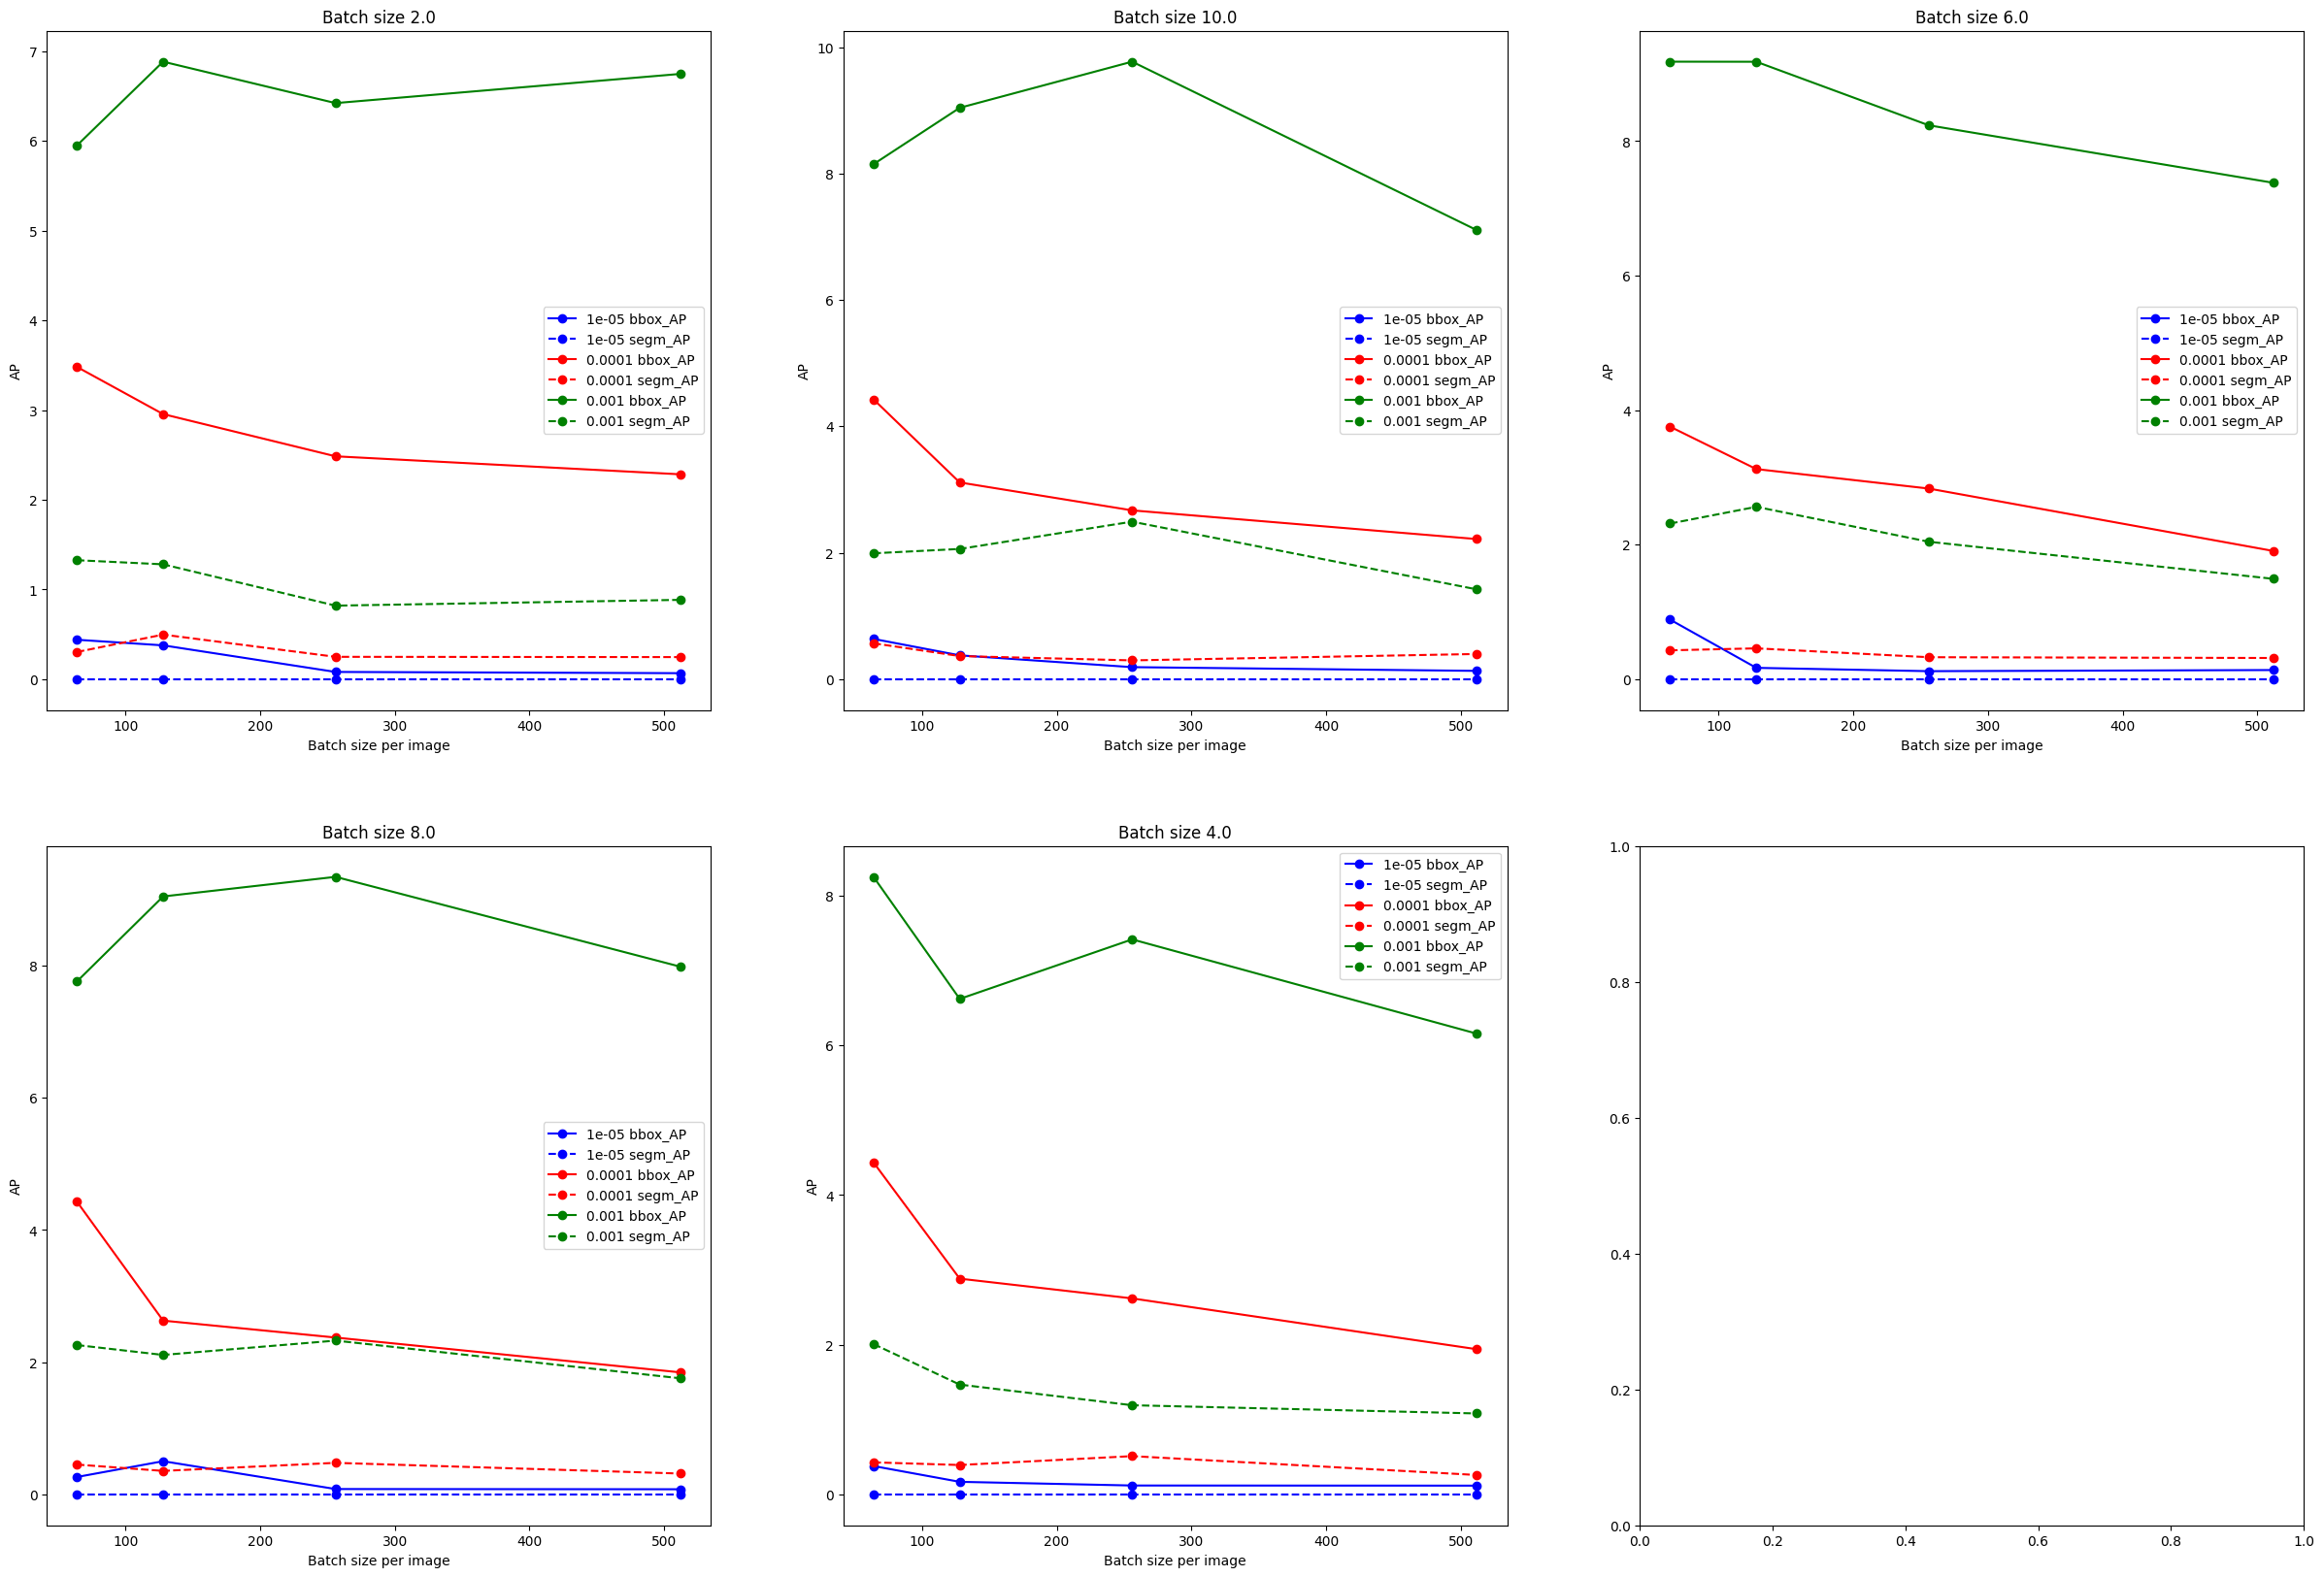

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

grouped_bs = reduces_df.groupby('Batch size')

fig, ax = plt.subplots(2,3, figsize=(30, 20))

# Define line styles
line_styles = ['-', '--']
labels = ['bbox_AP', 'segm_AP']
colors = ['blue', 'red', 'green', 'pink']

for i,(key, group) in enumerate(grouped_bs):
    if key in [2.0, 4.0, 6.0, 8.0, 10.0]:
        grouped_lr = group.groupby('Learning rate')
        for j,(key_lr, group_lr) in enumerate(grouped_lr):
            for k, metric in enumerate([group_lr['bbox_AP'], group_lr['segm_AP']]):
                ax[i%2][i%3].plot(group_lr['Batch size per image'], metric, marker='o', linestyle=line_styles[k], label=f'{key_lr} {labels[k]}', color=colors[j])
        ax[i%2][i%3].legend()
        ax[i%2][i%3].set_title(f'Batch size {key}')
        ax[i%2][i%3].set_xlabel('Batch size per image')
        ax[i%2][i%3].set_ylabel('AP')

plt.show()



According to the following figure, a pattern can start to be intuited. Clearly, as expected, the larger the batch size, the better the performance generally. Also, higher learning rates seem to be better, where in general 1e-5 does not learn in any model and 0.001 is the best, it might be worth trying higher learning rates. In relation to bspi, it can be seen that in configurations that seem optimal (bs=8,10 and lr=0.001) the best ranges seem to be 128,256. This may be because a low bspi causes not enough regions of interest to be proposed and a high bspi causes too many to be proposed.

### Folds

In [6]:
import re

def get_results(data):
    keys = ["bbox_AP", "segm_AP"]
    results = {}
    matches = re.findall(r'{.*?}', data)
    for i,match in enumerate(matches):
        match = ast.literal_eval(match)
        results[keys[i]] = match
    return results

In [7]:
#results = open("./../models/Glass_models/results.txt", "r")
results = open("./../models/CA_models/results.txt", "r")
results = results.readlines()
count = 0
data_dict = {}

for i, line in enumerate(results):
    line = line.strip("\n")
    if line == str(count):
        data_list = results[i+3:i+8]
        data_len = len(data_list)
        data = [d.split("OrderedDict")[1] for d in data_list]
        results_to_dict = [get_results(d) for d in data]
        fold_dict = {}
        for i, r in enumerate(results_to_dict):
            fold_dict[i] = r
        data_dict[count] = fold_dict
        count += 1

print(data_dict)

{0: {0: {'bbox_AP': {'AP': 4.7734737129427804, 'AP50': 8.989530029442136, 'AP75': 4.362921787283195, 'APs': 4.473245252616523, 'APm': 9.142170952246987, 'APl': 3.9871695432355074, 'AP-dark': 3.8082497562015005, 'AP-light': 5.7386976696840595}, 'segm_AP': {'AP': 1.0414130171954683, 'AP50': 3.463744396172618, 'AP75': 0.40743447758283874, 'APs': 0.926428629184059, 'APm': 5.749311823765495, 'APl': 6.6336633663366324, 'AP-dark': 0.8444195528295263, 'AP-light': 1.2384064815614109}}, 1: {'bbox_AP': {'AP': 6.307862786343121, 'AP50': 13.856631890692093, 'AP75': 3.7277426964035234, 'APs': 7.055028418610577, 'APm': 7.950105939015409, 'APl': 4.39595769717693, 'AP-dark': 5.975524737830154, 'AP-light': 6.6402008348560875}, 'segm_AP': {'AP': 1.169138364453331, 'AP50': 4.582444709573133, 'AP75': 0.0, 'APs': 1.8577531445301467, 'APm': 4.011743279591117, 'APl': 0.0, 'AP-dark': 1.6482777774346962, 'AP-light': 0.6899989514719659}}, 2: {'bbox_AP': {'AP': 8.771366499884211, 'AP50': 15.489608946083058, 'AP75

In [8]:
data_dict_unified = {}
for count in data_dict:
    for fold in data_dict[count]:
        for value in data_dict[count][fold]:
            for metric in data_dict[count][fold][value]:
                new_key = value + "_" + metric
                if count not in data_dict_unified:
                    data_dict_unified[count] = {}
                if fold not in data_dict_unified[count]:
                    data_dict_unified[count][fold] = {}
                data_dict_unified[count][fold][new_key] = data_dict[count][fold][value][metric]

print(data_dict_unified)

{0: {0: {'bbox_AP_AP': 4.7734737129427804, 'bbox_AP_AP50': 8.989530029442136, 'bbox_AP_AP75': 4.362921787283195, 'bbox_AP_APs': 4.473245252616523, 'bbox_AP_APm': 9.142170952246987, 'bbox_AP_APl': 3.9871695432355074, 'bbox_AP_AP-dark': 3.8082497562015005, 'bbox_AP_AP-light': 5.7386976696840595, 'segm_AP_AP': 1.0414130171954683, 'segm_AP_AP50': 3.463744396172618, 'segm_AP_AP75': 0.40743447758283874, 'segm_AP_APs': 0.926428629184059, 'segm_AP_APm': 5.749311823765495, 'segm_AP_APl': 6.6336633663366324, 'segm_AP_AP-dark': 0.8444195528295263, 'segm_AP_AP-light': 1.2384064815614109}, 1: {'bbox_AP_AP': 6.307862786343121, 'bbox_AP_AP50': 13.856631890692093, 'bbox_AP_AP75': 3.7277426964035234, 'bbox_AP_APs': 7.055028418610577, 'bbox_AP_APm': 7.950105939015409, 'bbox_AP_APl': 4.39595769717693, 'bbox_AP_AP-dark': 5.975524737830154, 'bbox_AP_AP-light': 6.6402008348560875, 'segm_AP_AP': 1.169138364453331, 'segm_AP_AP50': 4.582444709573133, 'segm_AP_AP75': 0.0, 'segm_AP_APs': 1.8577531445301467, 'seg

In [9]:
data_df = pd.concat({(i,j): pd.DataFrame(data_dict_unified[i][j], index=[0]) for i in data_dict_unified.keys() 
                for j in data_dict_unified[i].keys()}, axis=0)

# Reset the index
data_df.reset_index(inplace=True)

# Rename the columns
data_df.columns = ['OuterKey', 'InnerKey'] + list(data_df.columns[2:])
data_df = data_df.drop(columns=["level_2"])

# Print the DataFrame
data_df.head()

,OuterKey,InnerKey,bbox_AP_AP,bbox_AP_AP50,bbox_AP_AP75,bbox_AP_APs,bbox_AP_APm,bbox_AP_APl,bbox_AP_AP-dark,bbox_AP_AP-light,segm_AP_AP,segm_AP_AP50,segm_AP_AP75,segm_AP_APs,segm_AP_APm,segm_AP_APl,segm_AP_AP-dark,segm_AP_AP-light
0,0,0,4.773474,8.989530,4.362922,4.473245,9.142171,3.987170,3.808250,5.738698,1.041413,3.463744,0.407434,0.926429,5.749312,6.633663,0.844420,1.238406
1,0,1,6.307863,13.856632,3.727743,7.055028,7.950106,4.395958,5.975525,6.640201,1.169138,4.582445,0.000000,1.857753,4.011743,0.000000,1.648278,0.689999
2,0,2,8.771366,15.489609,9.276953,5.751056,11.835240,14.587031,4.504467,13.038266,1.667252,8.083497,0.108340,0.501007,9.464366,13.118812,0.872437,2.462067
3,0,3,4.784471,11.641908,2.318660,4.738936,7.830274,6.007449,5.297999,4.270943,0.732971,3.873108,0.015279,0.252303,6.526095,0.841584,0.560348,0.905595
4,0,4,5.103608,11.453938,2.975028,2.728801,8.148889,17.410440,1.846821,8.360395,2.021849,7.106528,0.040234,0.554201,14.311705,3.279440,0.431052,3.612646


In [10]:
data_df_bbox = data_df[['OuterKey', 'bbox_AP_AP']]
data_df_segm = data_df[['OuterKey', 'segm_AP_AP']]

In [11]:
grouped_data_bbox_df = data_df_bbox.groupby('OuterKey').describe()
grouped_data_segm_df = data_df_segm.groupby('OuterKey').describe()
grouped_data_bbox_df.head()


bbox_AP_AP                                                    \
              count      mean       std       min       25%       50%   
OuterKey                                                                
0               5.0  5.948156  1.699059  4.773474  4.784471  5.103608   
1               5.0  6.882418  2.273369  5.333064  5.522452  6.292344   
2               5.0  6.420652  1.773563  4.250256  5.363836  6.025874   
3               5.0  6.746012  2.186200  3.283693  5.901728  7.818873   
4               5.0  3.480816  1.081180  2.385767  2.591479  3.227886   

                               
               75%        max  
OuterKey                       
0         6.307863   8.771366  
1         6.401447  10.862782  
2         8.091338   8.371955  
3         8.225318   8.500448  
4         4.355563   4.843385

In [12]:
grouped_data_segm_df.head()

segm_AP_AP                                                    \
              count      mean       std       min       25%       50%   
OuterKey                                                                
0               5.0  1.326525  0.514280  0.732971  1.041413  1.169138   
1               5.0  1.280634  0.486689  0.648900  1.012655  1.302552   
2               5.0  0.820108  0.071922  0.712424  0.805213  0.825140   
3               5.0  0.884714  0.449234  0.365951  0.497800  0.967348   
4               5.0  0.303760  0.118169  0.174646  0.218353  0.274465   

                              
               75%       max  
OuterKey                      
0         1.667252  2.021849  
1         1.506437  1.932628  
2         0.847740  0.910023  
3         1.149773  1.442696  
4         0.400073  0.451262

Text(0, 0.5, 'Value')

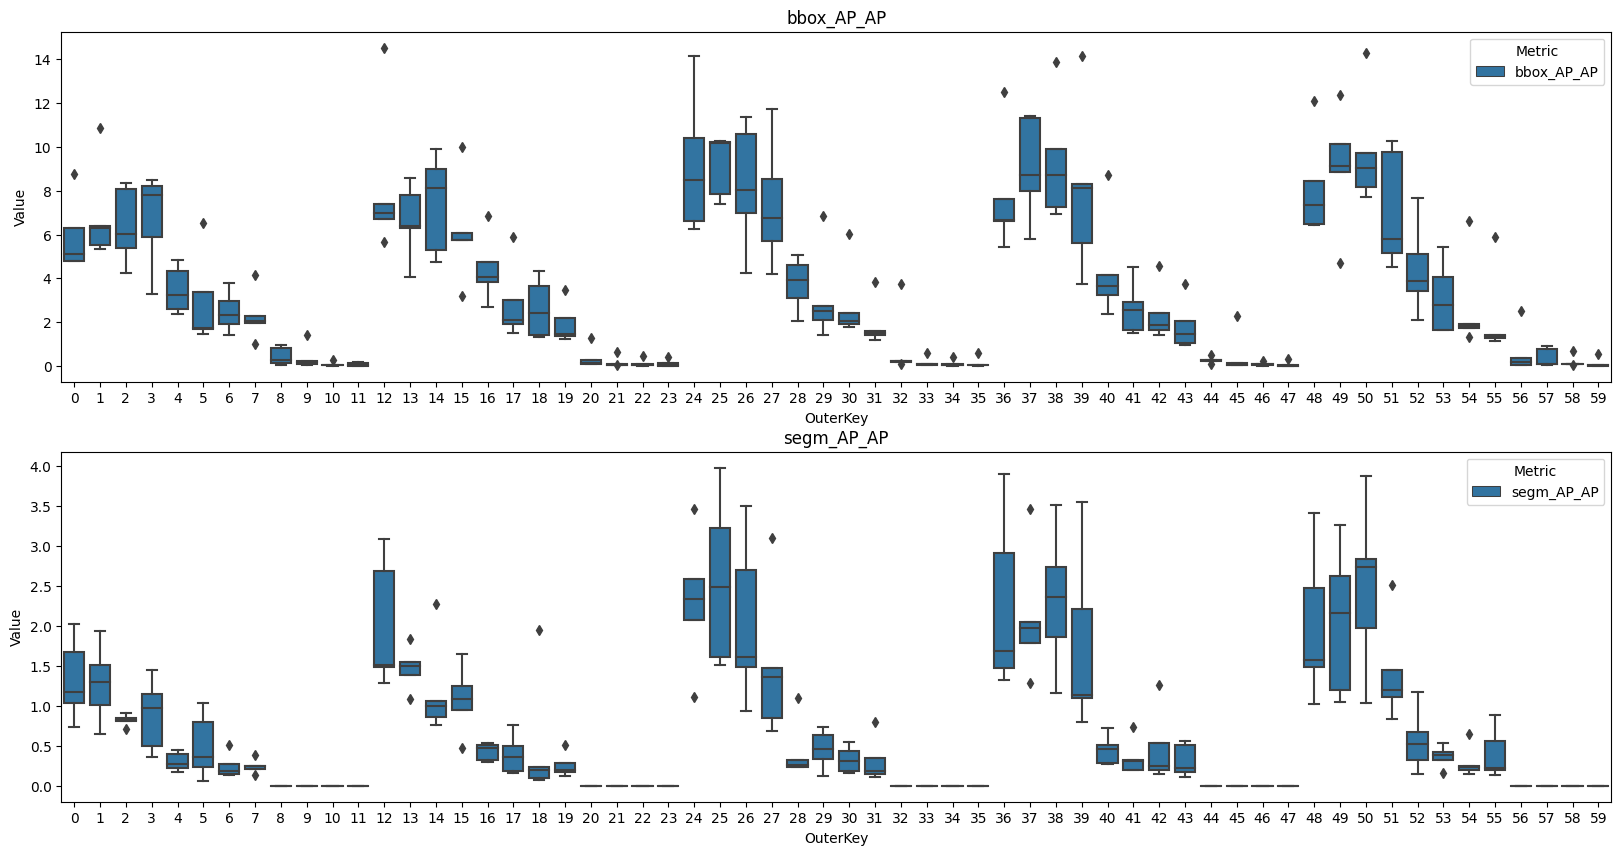

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

melted_bbox_df = data_df_bbox.melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
sns.boxplot(x='OuterKey', y='Value', data=melted_bbox_df, hue='Metric', ax=ax[0])
ax[0].set_title('bbox_AP_AP')
ax[0].set_xlabel('OuterKey')
ax[0].set_ylabel('Value')

melted_segm_df = data_df_segm.melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
sns.boxplot(x='OuterKey', y='Value', data=melted_segm_df, hue='Metric', ax=ax[1])
ax[1].set_title('segm_AP_AP')
ax[1].set_xlabel('OuterKey')
ax[1].set_ylabel('Value')

In [14]:
# Save a new df for sections of 12 rows of oute key of grouped_bbox_data_bbox_df
grouped_bbox_data_0_11 = grouped_data_bbox_df[0:12]
grouped_bbox_data_12_23 = grouped_data_bbox_df[12:24]
grouped_bbox_data_24_35 = grouped_data_bbox_df[24:36]
grouped_bbox_data_36_47 = grouped_data_bbox_df[36:48]
grouped_bbox_data_48_59 = grouped_data_bbox_df[48:60]
print(grouped_bbox_data_0_11.shape, grouped_bbox_data_24_35.shape, grouped_bbox_data_36_47.shape, grouped_bbox_data_48_59.shape)
grouped_bbox_data_0_11.head()

(12, 8) (12, 8) (12, 8) (12, 8)


bbox_AP_AP                                                    \
              count      mean       std       min       25%       50%   
OuterKey                                                                
0               5.0  5.948156  1.699059  4.773474  4.784471  5.103608   
1               5.0  6.882418  2.273369  5.333064  5.522452  6.292344   
2               5.0  6.420652  1.773563  4.250256  5.363836  6.025874   
3               5.0  6.746012  2.186200  3.283693  5.901728  7.818873   
4               5.0  3.480816  1.081180  2.385767  2.591479  3.227886   

                               
               75%        max  
OuterKey                       
0         6.307863   8.771366  
1         6.401447  10.862782  
2         8.091338   8.371955  
3         8.225318   8.500448  
4         4.355563   4.843385

In [15]:
grouped_segm_data_0_11 = grouped_data_segm_df[0:12]
grouped_segm_data_12_23 = grouped_data_segm_df[12:24]
grouped_segm_data_24_35 = grouped_data_segm_df[24:36]
grouped_segm_data_36_47 = grouped_data_segm_df[36:48]
grouped_segm_data_48_59 = grouped_data_segm_df[48:60]
print(grouped_segm_data_0_11.shape, grouped_segm_data_24_35.shape, grouped_segm_data_36_47.shape, grouped_segm_data_48_59.shape)
grouped_segm_data_0_11.head()

(12, 8) (12, 8) (12, 8) (12, 8)


segm_AP_AP                                                    \
              count      mean       std       min       25%       50%   
OuterKey                                                                
0               5.0  1.326525  0.514280  0.732971  1.041413  1.169138   
1               5.0  1.280634  0.486689  0.648900  1.012655  1.302552   
2               5.0  0.820108  0.071922  0.712424  0.805213  0.825140   
3               5.0  0.884714  0.449234  0.365951  0.497800  0.967348   
4               5.0  0.303760  0.118169  0.174646  0.218353  0.274465   

                              
               75%       max  
OuterKey                      
0         1.667252  2.021849  
1         1.506437  1.932628  
2         0.847740  0.910023  
3         1.149773  1.442696  
4         0.400073  0.451262

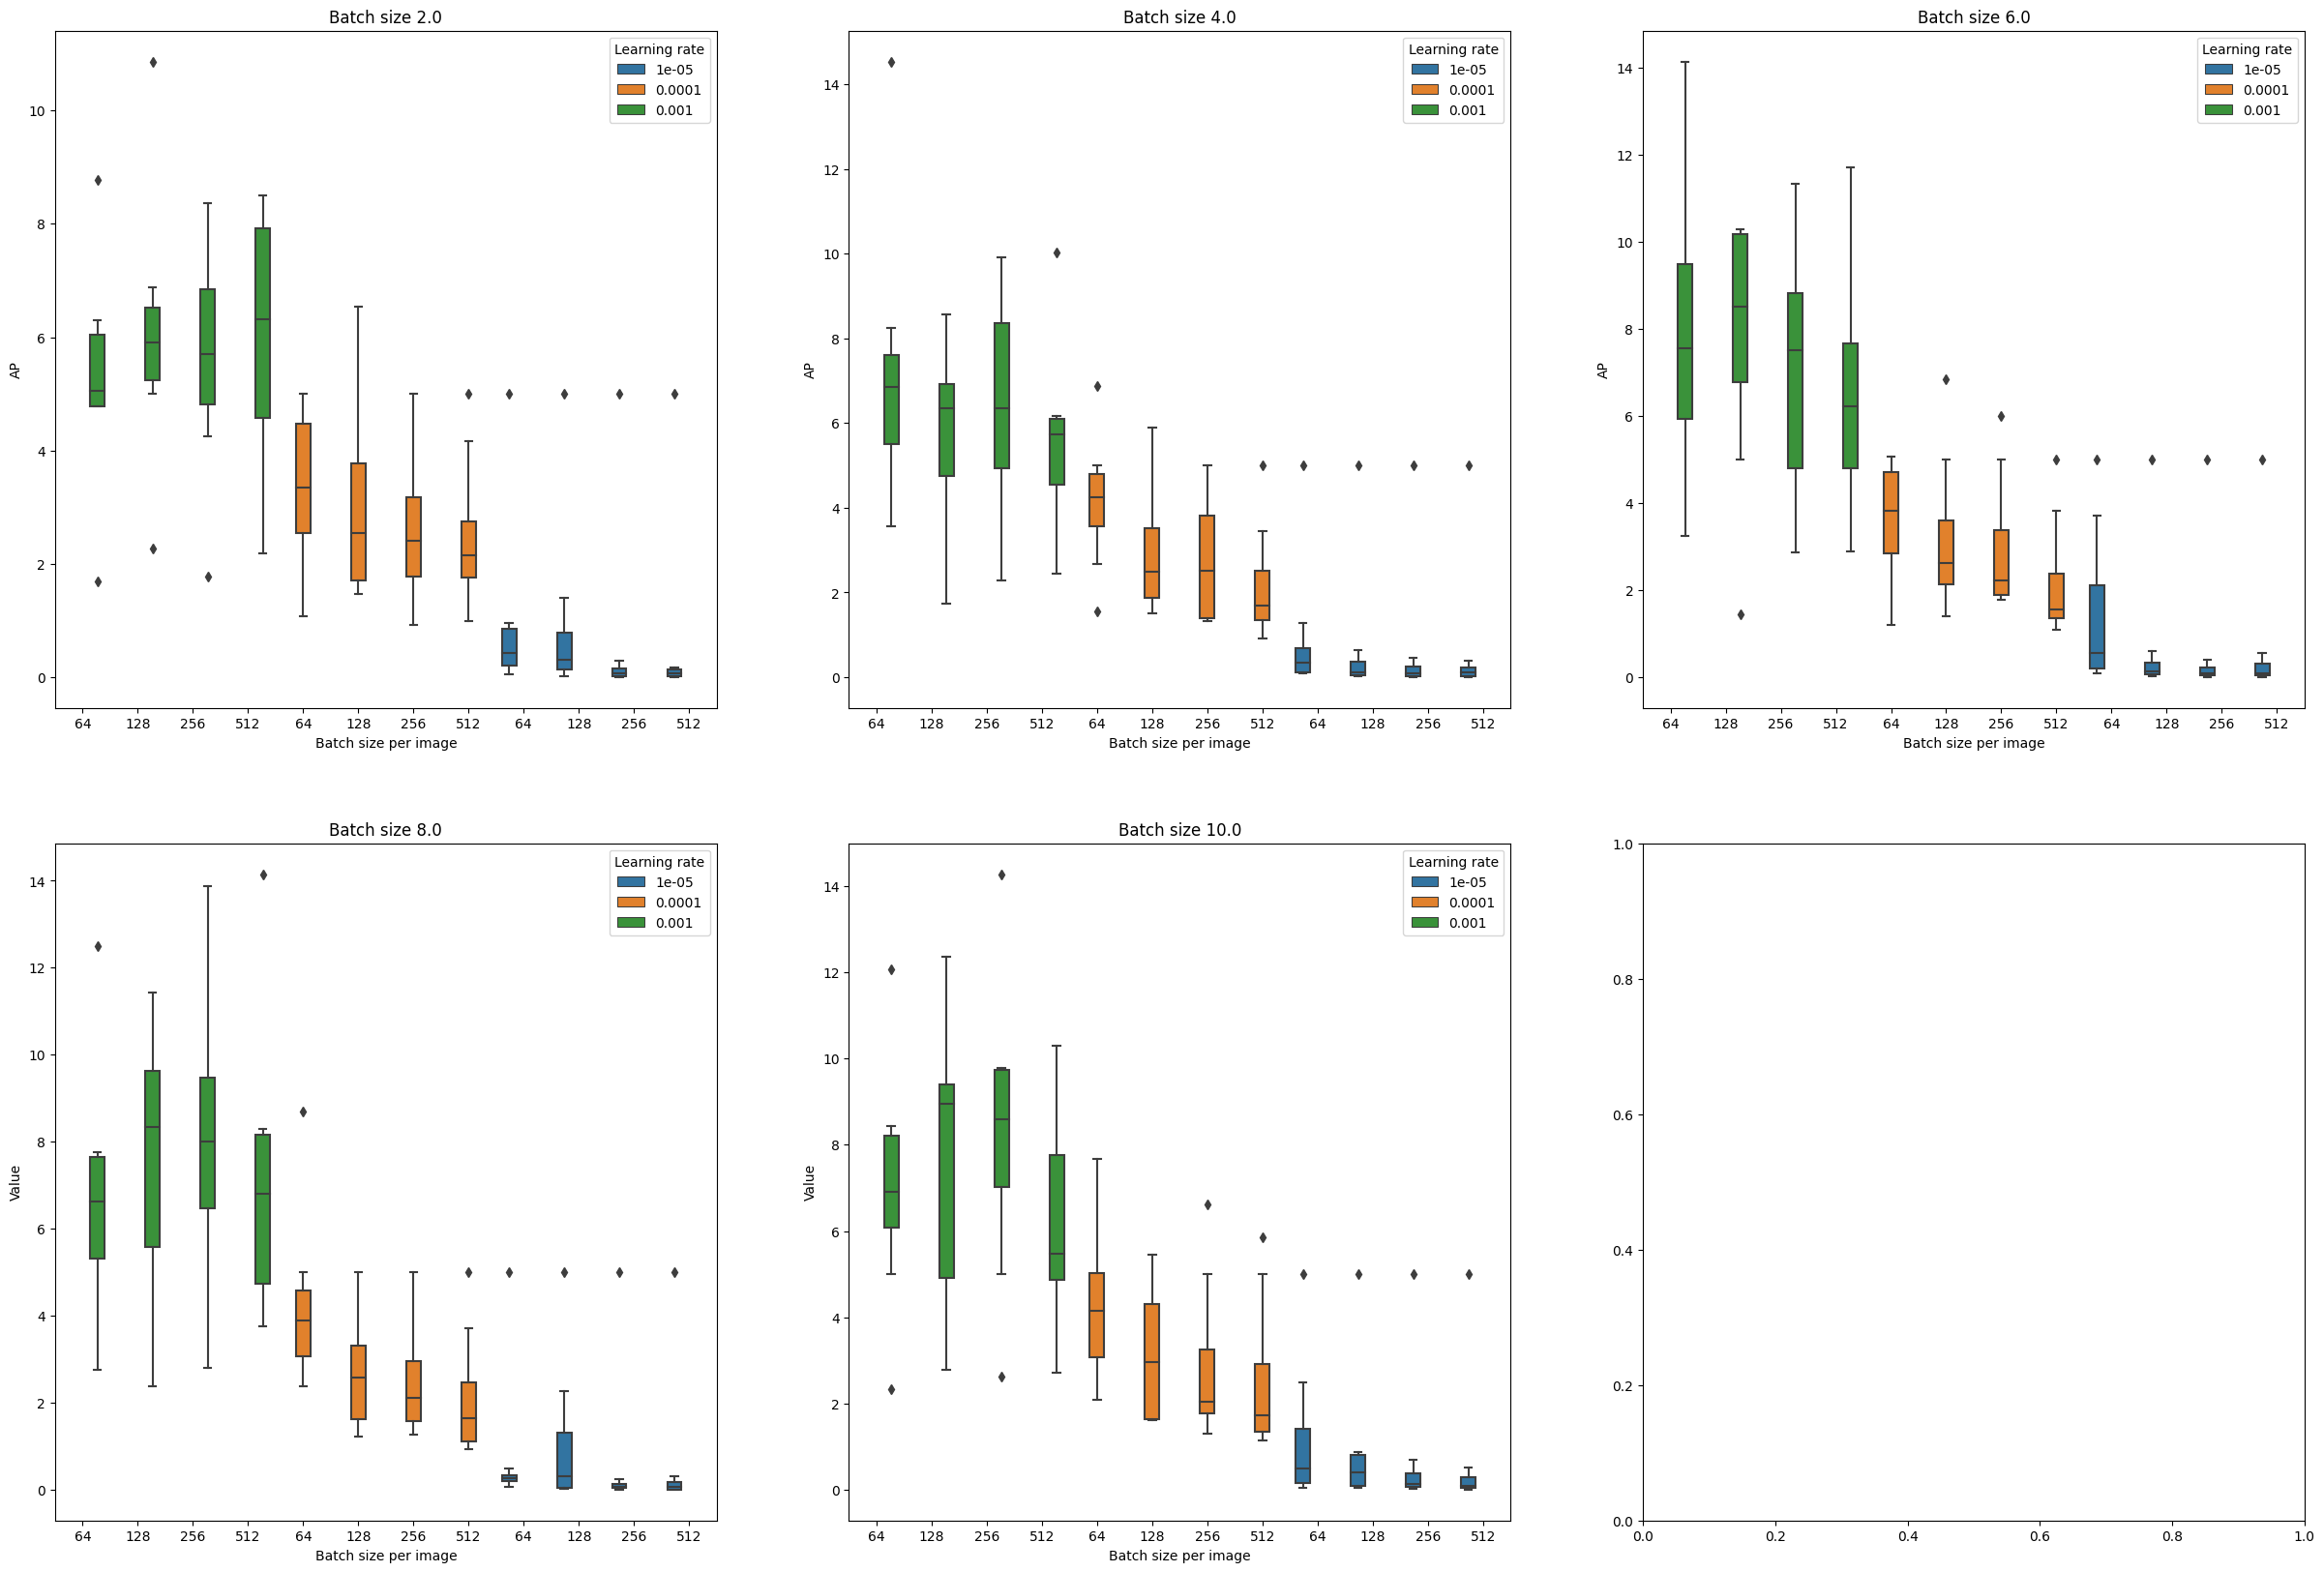

In [16]:
x_value = [64,128,256,512]*3
x_values_df = pd.DataFrame(x_value, columns=['Batch size per image'])

hue_labels = [0.001, 0.001, 0.001, 0.001, 0.0001, 0.0001, 0.0001, 0.0001, 0.00001, 0.00001, 0.00001, 0.00001]

fig, ax = plt.subplots(2, 3, figsize=(30, 20))

melt_bbox_0_11 = grouped_bbox_data_0_11.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_0_11['Learning rate'] = melt_bbox_0_11['OuterKey'].map(dict(enumerate(hue_labels)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_0_11, hue='Learning rate', ax=ax[0][0])
ax[0][0].set_xticklabels(x_values_df['Batch size per image'])
ax[0][0].set_xlabel('Batch size per image')
ax[0][0].set_ylabel('AP')
ax[0][0].set_title('Batch size 2.0')

melt_bbox_12_23 = grouped_bbox_data_12_23.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_12_23['Learning rate'] = melt_bbox_12_23['OuterKey'].map(dict(enumerate(hue_labels, start=12)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_12_23, hue='Learning rate', ax=ax[0][1])
ax[0][1].set_title('Batch size 4.0')
ax[0][1].set_xticklabels(x_values_df['Batch size per image'])
ax[0][1].set_xlabel('Batch size per image')
ax[0][1].set_ylabel('AP')

melt_bbox_24_35 = grouped_bbox_data_24_35.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_24_35['Learning rate'] = melt_bbox_24_35['OuterKey'].map(dict(enumerate(hue_labels,start=24)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_24_35, hue='Learning rate', ax=ax[0][2])
ax[0][2].set_title('Batch size 6.0')
ax[0][2].set_xticklabels(x_values_df['Batch size per image'])
ax[0][2].set_xlabel('Batch size per image')
ax[0][2].set_ylabel('AP')

melt_bbox_36_47 = grouped_bbox_data_36_47.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_36_47['Learning rate'] = melt_bbox_36_47['OuterKey'].map(dict(enumerate(hue_labels, start=36)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_36_47, hue='Learning rate', ax=ax[1][0])
ax[1][0].set_title('Batch size 8.0')
ax[1][0].set_xticklabels(x_values_df['Batch size per image'])
ax[1][0].set_xlabel('Batch size per image')

melt_bbox_48_59 = grouped_bbox_data_48_59.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_48_59['Learning rate'] = melt_bbox_48_59['OuterKey'].map(dict(enumerate(hue_labels, start=48)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_48_59, hue='Learning rate', ax=ax[1][1])
ax[1][1].set_title('Batch size 10.0')
ax[1][1].set_xticklabels(x_values_df['Batch size per image'])
ax[1][1].set_xlabel('Batch size per image')

plt.show()


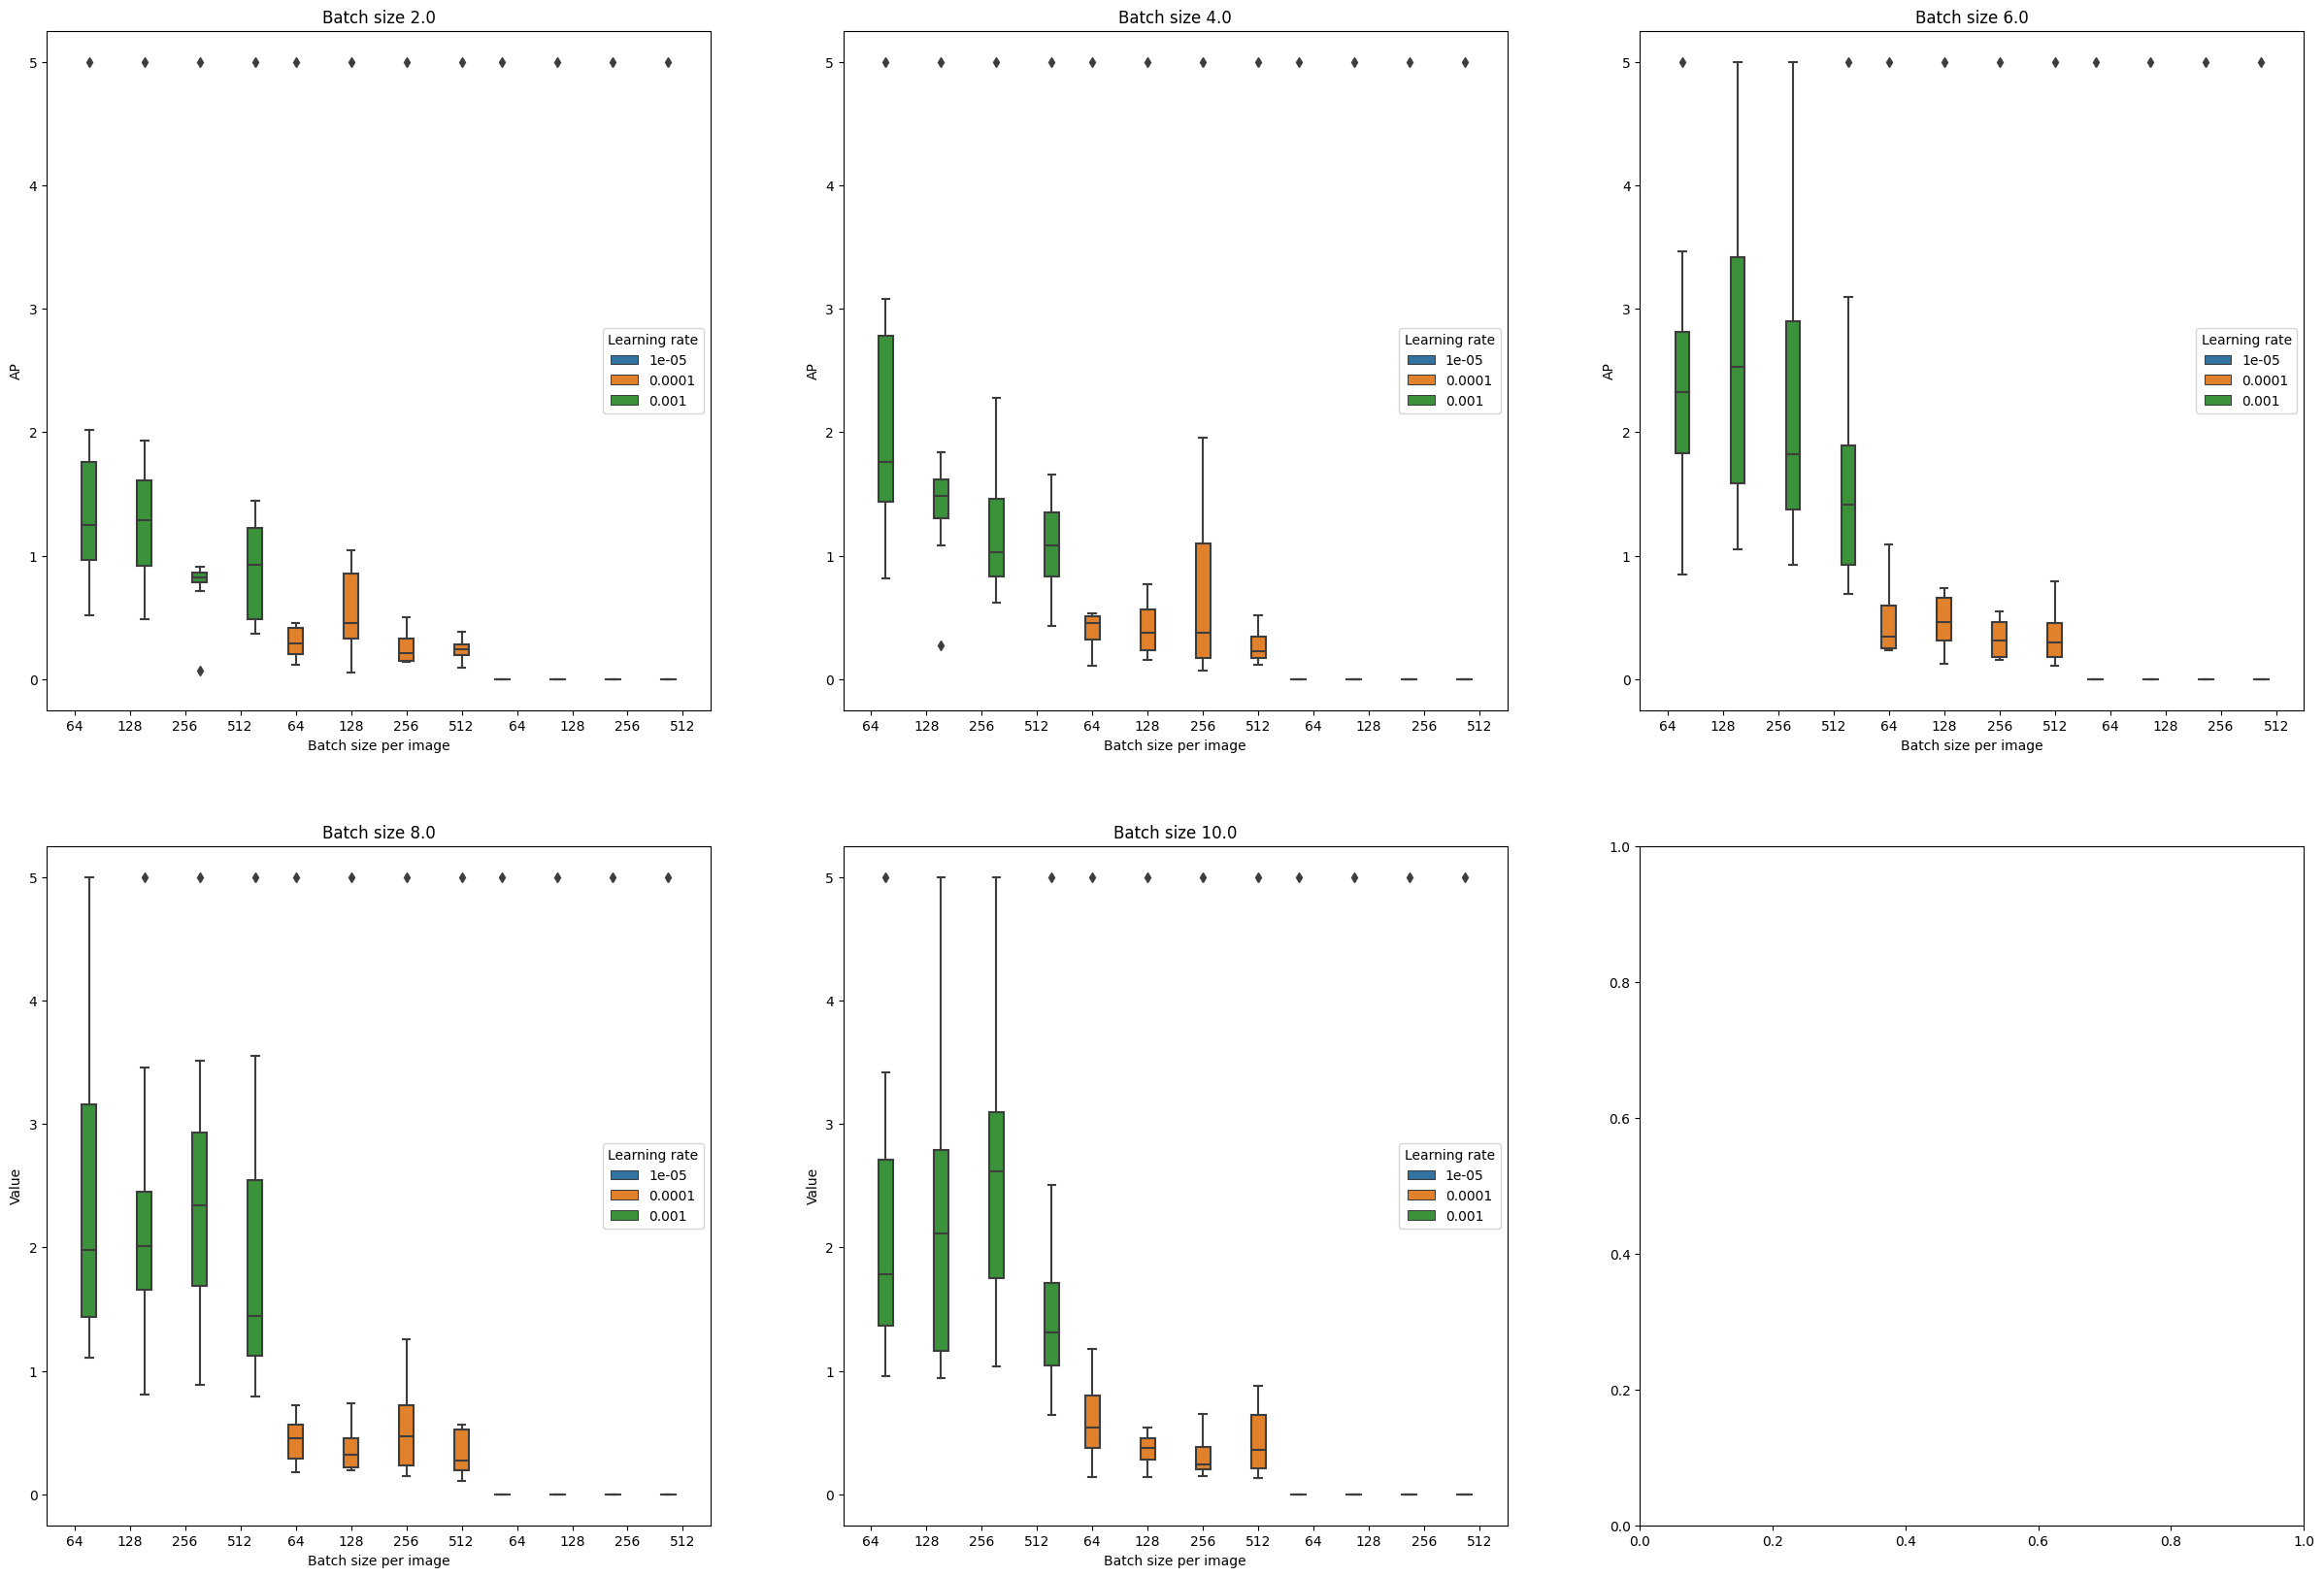

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))

melt_segm_0_11 = grouped_segm_data_0_11.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_0_11['Learning rate'] = melt_segm_0_11['OuterKey'].map(dict(enumerate(hue_labels)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_0_11, hue='Learning rate', ax=ax[0][0])
ax[0][0].set_xticklabels(x_values_df['Batch size per image'])
ax[0][0].set_xlabel('Batch size per image')
ax[0][0].set_ylabel('AP')
ax[0][0].set_title('Batch size 2.0')

melt_segm_12_23 = grouped_segm_data_12_23.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_12_23['Learning rate'] = melt_segm_12_23['OuterKey'].map(dict(enumerate(hue_labels, start=12)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_12_23, hue='Learning rate', ax=ax[0][1])
ax[0][1].set_title('Batch size 4.0')
ax[0][1].set_xticklabels(x_values_df['Batch size per image'])
ax[0][1].set_xlabel('Batch size per image')
ax[0][1].set_ylabel('AP')

melt_segm_24_35 = grouped_segm_data_24_35.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_24_35['Learning rate'] = melt_segm_24_35['OuterKey'].map(dict(enumerate(hue_labels,start=24)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_24_35, hue='Learning rate', ax=ax[0][2])
ax[0][2].set_title('Batch size 6.0')
ax[0][2].set_xticklabels(x_values_df['Batch size per image'])
ax[0][2].set_xlabel('Batch size per image')
ax[0][2].set_ylabel('AP')

melt_segm_36_47 = grouped_segm_data_36_47.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_36_47['Learning rate'] = melt_segm_36_47['OuterKey'].map(dict(enumerate(hue_labels, start=36)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_36_47, hue='Learning rate', ax=ax[1][0])
ax[1][0].set_title('Batch size 8.0')
ax[1][0].set_xticklabels(x_values_df['Batch size per image'])
ax[1][0].set_xlabel('Batch size per image')

melt_segm_48_59 = grouped_segm_data_48_59.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_48_59['Learning rate'] = melt_segm_48_59['OuterKey'].map(dict(enumerate(hue_labels, start=48)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_48_59, hue='Learning rate', ax=ax[1][1])
ax[1][1].set_title('Batch size 10.0')
ax[1][1].set_xticklabels(x_values_df['Batch size per image'])
ax[1][1].set_xlabel('Batch size per image')

plt.show()


For both bbox and segm, the same tendency as before is shown, however now is more clear. Higher bs result in better performing, beeing the best performance bs of 8 and 10. In both bs a lr of 0.001 is the best. Also the best bspi is 128 and 256. The spected increase of the std in better performing models is expected, as nn are high variance low bias models, as they fit better to the training data, the scores in the test set will vary more. The goal is to find the best tradeoff.

# Metrics

In [18]:
import os
import pandas as pd
from tensorflow.python.summary.summary_iterator import summary_iterator

def convert_tb_data(root_dir, sort_by=None):
    def convert_tfevent(filepath):
        return pd.DataFrame([parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)])

    def parse_tfevent(tfevent):
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tfevent.summary.value[0].simple_value),
        )

    columns_order = ['wall_time', 'name', 'step', 'value']
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by:
        all_df = all_df.sort_values(by=sort_by)
    return all_df


2024-03-31 11:48:35.486271: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [19]:
model_38_0 = convert_tb_data("./../models/CA_models/model_1/0")
model_38_1 = convert_tb_data("./../models/CA_models/model_1/1")
model_38_2 = convert_tb_data("./../models/CA_models/model_1/2")
model_38_3 = convert_tb_data("./../models/CA_models/model_1/3")
model_38_4 = convert_tb_data("./../models/CA_models/model_1/4")
model_38_0.head()

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


,wall_time,name,step,value
0,1.711042e+09,data_time,18,0.289651
1,1.711042e+09,rpn/num_pos_anchors,19,7.800000
2,1.711042e+09,rpn/num_neg_anchors,19,248.199997
3,1.711042e+09,roi_head/num_fg_samples,19,3.550000
4,1.711042e+09,roi_head/num_bg_samples,19,252.449997


In [20]:
model_50_0 = convert_tb_data("./../models/CA_models/model_50/0")
model_50_1 = convert_tb_data("./../models/CA_models/model_50/1")
model_50_2 = convert_tb_data("./../models/CA_models/model_50/2")
model_50_3 = convert_tb_data("./../models/CA_models/model_50/3")
model_50_4 = convert_tb_data("./../models/CA_models/model_50/4")
model_50_0.head()

,wall_time,name,step,value
0,1.711099e+09,data_time,18,0.288756
1,1.711099e+09,rpn/num_pos_anchors,19,8.500000
2,1.711099e+09,rpn/num_neg_anchors,19,247.500000
3,1.711099e+09,roi_head/num_fg_samples,19,3.050000
4,1.711099e+09,roi_head/num_bg_samples,19,252.949997


In [21]:
model_38_0_metrics = model_38_0.pivot(index='step', columns='name', values='value')
model_38_0_metrics = model_38_0_metrics.dropna(how='all')
model_38_0_metrics_eval = model_38_0_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_1_metrics = model_38_1.pivot(index='step', columns='name', values='value')
model_38_1_metrics = model_38_1_metrics.dropna(how='all')
model_38_1_metrics_eval = model_38_1_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_2_metrics = model_38_2.pivot(index='step', columns='name', values='value')
model_38_2_metrics = model_38_2_metrics.dropna(how='all')
model_38_2_metrics_eval = model_38_2_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_3_metrics = model_38_3.pivot(index='step', columns='name', values='value')
model_38_3_metrics = model_38_3_metrics.dropna(how='all')
model_38_3_metrics_eval = model_38_3_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_4_metrics = model_38_4.pivot(index='step', columns='name', values='value')
model_38_4_metrics = model_38_4_metrics.dropna(how='all')
model_38_4_metrics_eval = model_38_4_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

In [22]:
model_50_0_metrics = model_50_0.pivot(index='step', columns='name', values='value')
model_50_0_metrics = model_50_0_metrics.dropna(how='all')
model_50_0_metrics_eval = model_50_0_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_50_1_metrics = model_50_1.pivot(index='step', columns='name', values='value')
model_50_1_metrics = model_50_1_metrics.dropna(how='all')
model_50_1_metrics_eval = model_50_1_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_50_2_metrics = model_50_2.pivot(index='step', columns='name', values='value')
model_50_2_metrics = model_50_2_metrics.dropna(how='all')
model_50_2_metrics_eval = model_50_2_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_50_3_metrics = model_50_3.pivot(index='step', columns='name', values='value')
model_50_3_metrics = model_50_3_metrics.dropna(how='all')
model_50_3_metrics_eval = model_50_3_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_50_4_metrics = model_50_4.pivot(index='step', columns='name', values='value')
model_50_4_metrics = model_50_4_metrics.dropna(how='all')
model_50_4_metrics_eval = model_50_4_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_0_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
99,1.660766,4.151787,0.921863,4.345999,1.909278,2.270732,NaN,3312.406982,0.949609,0.992958,...,248.100006,7.90,0.114778,0.348033,0.010691,0.000000,4.900990,0.126340,0.684914,0.555611
199,2.049290,4.820814,1.386094,3.537551,2.677688,2.652830,NaN,3291.118408,0.958984,0.534847,...,249.100006,6.90,0.244445,0.869583,0.013162,1.039604,4.883740,0.241511,0.692372,0.434210
299,2.437815,5.489841,1.850326,4.345999,3.446099,2.701111,NaN,3233.345703,0.961328,0.321875,...,248.899994,7.10,0.374112,1.391132,0.015633,2.079208,4.900990,0.356683,0.702980,0.418512
399,2.810951,5.710367,2.496889,4.324191,3.885623,2.868019,NaN,3178.194336,0.962109,0.276714,...,248.000000,8.00,0.458138,1.580723,0.095919,2.599010,4.963678,0.368291,0.697039,0.381044
499,3.184088,5.930894,3.143453,4.302382,4.325148,3.034927,NaN,3117.369385,0.975391,0.245370,...,249.250000,6.75,0.542164,1.770313,0.136305,3.118812,5.026365,0.379900,0.698295,0.350172


In [23]:
model_38_avg_metrics = (model_38_0_metrics + model_38_1_metrics + model_38_2_metrics + model_38_3_metrics + model_38_4_metrics) / 5
model_38_avg_metrics_eval = model_38_avg_metrics.dropna(subset=['bbox/AP', 'segm/AP'])
model_38_avg_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
99,2.318674,6.104612,0.786495,4.691034,3.022407,3.552905,NaN,3401.404443,0.948945,0.996068,...,248.550000,7.45,0.180678,1.260409,0.003140,0.000000,2.924346,0.081650,0.716851,0.565271
199,3.502463,7.595877,2.651088,7.346697,4.526527,4.264102,NaN,3324.468652,0.958242,0.461712,...,248.989996,7.01,0.610142,2.783219,0.055644,1.795689,4.763134,0.354489,0.698492,0.434828
299,4.667199,9.087141,4.465030,9.114503,6.030648,4.380290,NaN,3262.530078,0.962031,0.333004,...,248.579999,7.42,0.864609,3.514005,0.045843,1.178218,6.111004,0.412219,0.718739,0.392614
399,5.547167,10.485538,5.306956,8.772960,7.273590,4.985693,NaN,3203.400000,0.966367,0.252796,...,248.869998,7.13,1.003694,4.153002,0.095655,1.405837,7.427676,0.522609,0.717490,0.369060
499,6.427136,11.883935,6.171699,9.374646,8.516531,5.634836,NaN,3142.634424,0.970430,0.224775,...,248.760001,7.24,1.142779,4.792000,0.126808,1.591378,8.744348,0.633000,0.727809,0.350550


In [24]:
model_50_avg_metrics = (model_50_0_metrics + model_50_1_metrics + model_50_2_metrics + model_50_3_metrics + model_50_4_metrics) / 5
model_50_avg_metrics_eval = model_50_avg_metrics.dropna(subset=['bbox/AP', 'segm/AP'])
model_50_avg_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
99,0.107044,0.323619,0.065091,0.361729,0.207416,0.689742,NaN,3350.643555,0.980039,1.000000,...,248.830002,7.17,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.704995,0.707863
199,0.465007,1.394281,0.113208,1.032144,0.721110,1.069340,NaN,3291.631006,0.957500,1.000000,...,248.759998,7.24,0.000008,0.000077,0.000000,0.0,0.000000,0.000017,0.701560,0.585547
299,0.822970,2.464943,0.179816,1.702558,1.234806,1.456283,NaN,3240.458643,0.955352,0.944897,...,247.860001,8.14,0.000015,0.000155,0.000000,0.0,0.000000,0.000034,0.724692,0.523507
399,1.498171,4.062045,0.593075,2.496620,2.063919,2.345222,NaN,3176.057959,0.960547,0.660046,...,248.520001,7.48,0.109304,0.446847,0.040188,0.0,1.398370,0.107810,0.724641,0.460446
499,2.173373,5.659146,1.006334,3.290681,2.893033,2.905582,NaN,3109.614209,0.962617,0.489630,...,248.460001,7.54,0.218592,0.893540,0.080376,0.0,2.796741,0.196159,0.719829,0.432700


In [25]:
model_50_avg_metrics.columns

Index(['bbox/AP', 'bbox/AP50', 'bbox/AP75', 'bbox/APl', 'bbox/APm', 'bbox/APs',
       'data_time', 'eta_seconds', 'fast_rcnn/cls_accuracy',
       'fast_rcnn/false_negative', 'fast_rcnn/fg_cls_accuracy', 'loss_box_reg',
       'loss_cls', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc', 'lr',
       'mask_rcnn/accuracy', 'mask_rcnn/false_negative',
       'mask_rcnn/false_positive', 'roi_head/num_bg_samples',
       'roi_head/num_fg_samples', 'rpn/num_neg_anchors', 'rpn/num_pos_anchors',
       'segm/AP', 'segm/AP50', 'segm/AP75', 'segm/APl', 'segm/APm', 'segm/APs',
       'time', 'total_loss'],
      dtype='object', name='name')

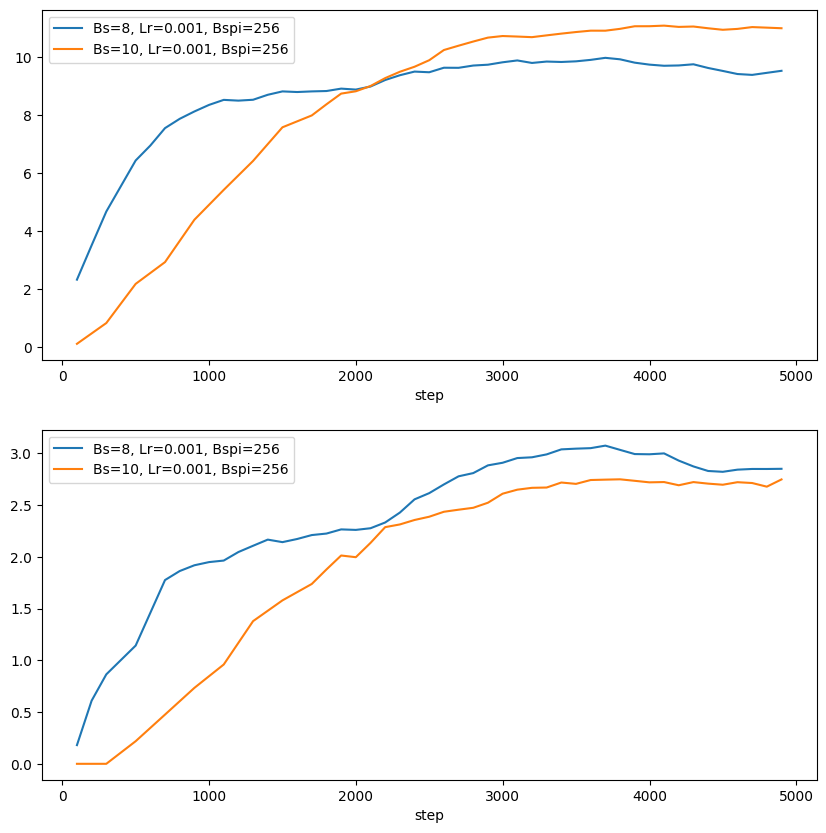

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

model_38_avg_metrics_eval.plot(y='bbox/AP', ax=ax[0], label='Bs=8, Lr=0.001, Bspi=256')
model_50_avg_metrics_eval.plot(y='bbox/AP', ax=ax[0], label='Bs=10, Lr=0.001, Bspi=256')
model_38_avg_metrics_eval.plot(y='segm/AP', ax=ax[1], label='Bs=8, Lr=0.001, Bspi=256')
model_50_avg_metrics_eval.plot(y='segm/AP', ax=ax[1], label='Bs=10, Lr=0.001, Bspi=256')

plt.show()

Comparing our two best performant models we can see that in bbox AP model 50 works better. It starts learning slower but is better guided to the optimal solution, in contrast to model 38 that starts learning faster but quickly platues and does not improve. In segm eventhough is tighter, model 38 wins by a margin, however its behaviour is less expected, it learns quicly but looks like its going to plateu but then it improves before overfitting and decreasing in performance. In the contrary model 50 starts learning slower but is more stable and improves more steadily.

## Overfitting

Given the results comparing both models, it can be seen that model 50 is more stable and yield a better performance. This is because it is less prone to overfitting, as it learns slower but more steadily. Now that we have stablished the best resulting model, we can evaluate the overfitting of the model by comparing the performance in training and validation. 

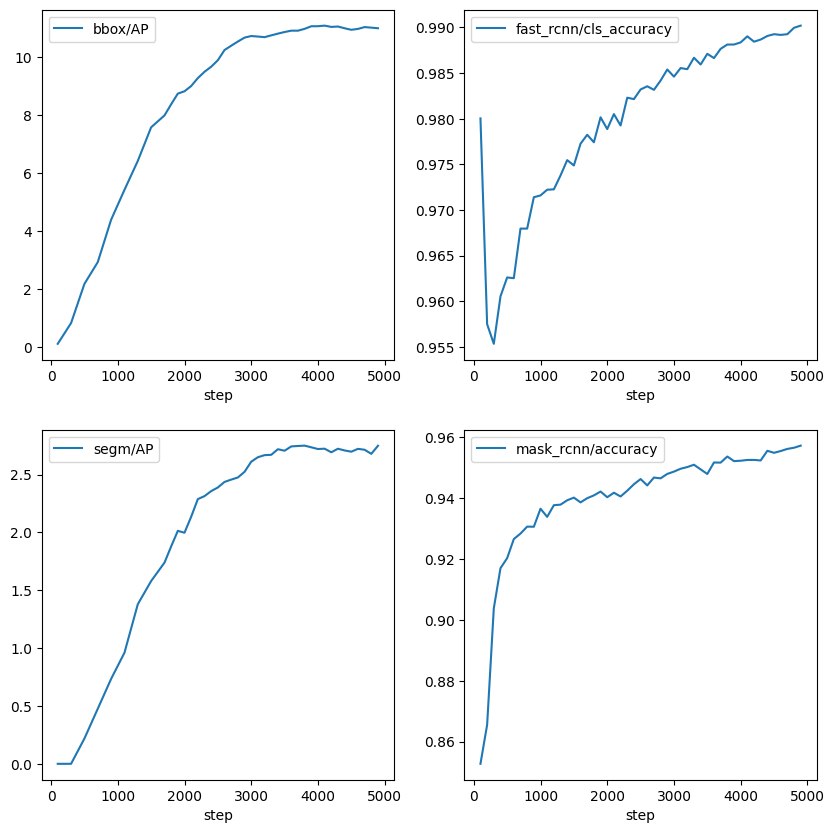

In [27]:
# Plot the curve of the average of model 50 that compares bbox/AP to fast_rcnn/cls_accuracy and segm/AP to mask_rcnn/accuracy, set log scale on the y-axis
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

model_50_avg_metrics_eval.plot(y='bbox/AP', ax=ax[0][0], label='bbox/AP')
model_50_avg_metrics_eval.plot(y='fast_rcnn/cls_accuracy', ax=ax[0][1], label='fast_rcnn/cls_accuracy')
model_50_avg_metrics_eval.plot(y='segm/AP', ax=ax[1][0], label='segm/AP')
model_50_avg_metrics_eval.plot(y='mask_rcnn/accuracy', ax=ax[1][1], label='mask_rcnn/accuracy')
plt.show()

From the following figure we can conclude that the model evaluation curve flats out around the epoch 2800/3000 however the training curve keeps improving. This is a clear sign of overfitting. So the best epoch to stop training would be around 3000/3300 this is when the model starts to overfit.

In [35]:
final_model_epoch_3500 = model_50_avg_metrics_eval.iloc[34]
final_model_epoch_3500

name
bbox/AP                        10.855080
bbox/AP50                      17.709597
bbox/AP75                      11.594181
bbox/APl                       13.275138
bbox/APm                       15.583017
bbox/APs                        9.401237
data_time                            NaN
eta_seconds                  1067.758276
fast_rcnn/cls_accuracy          0.987109
fast_rcnn/false_negative        0.066025
fast_rcnn/fg_cls_accuracy       0.933656
loss_box_reg                    0.079743
loss_cls                        0.033375
loss_mask                       0.116497
loss_rpn_cls                    0.000766
loss_rpn_loc                    0.006268
lr                              0.001000
mask_rcnn/accuracy              0.947965
mask_rcnn/false_negative        0.169460
mask_rcnn/false_positive        0.030239
roi_head/num_bg_samples       235.670001
roi_head/num_fg_samples        20.330000
rpn/num_neg_anchors           249.029999
rpn/num_pos_anchors             6.970000
segm/AP    

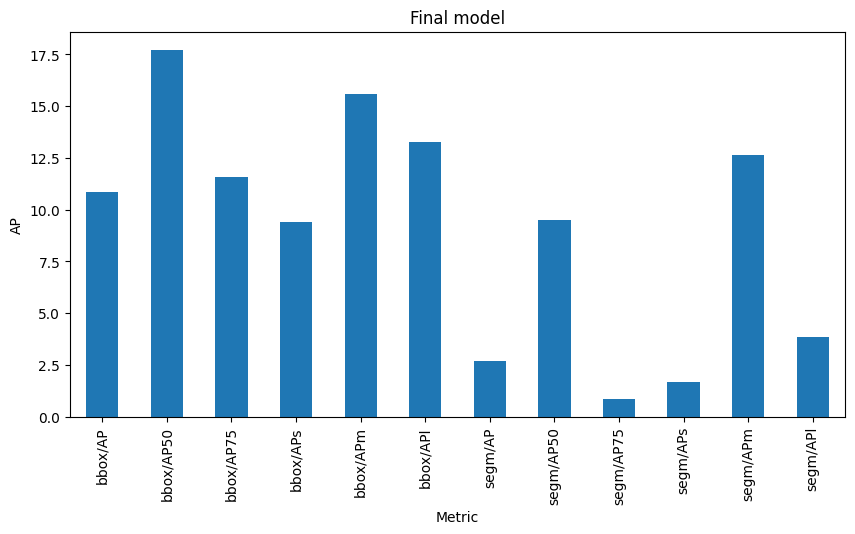

In [39]:
# Bar plot for the final model at epoch 3500
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

final_model_epoch_3500[['bbox/AP', 'bbox/AP50', 'bbox/AP75', 'bbox/APs', 'bbox/APm', 'bbox/APl', 'segm/AP', 'segm/AP50', 'segm/AP75', 'segm/APs', 'segm/APm', 'segm/APl']].plot(kind='bar', ax=ax)
ax.set_title('Final model')
ax.set_ylabel('AP')
ax.set_xlabel('Metric')

plt.show()

# Final model

Final model trained on all data for 3500 epoch, configuration bs=10, lr=0.001, bspi=256

In [30]:
final_model = convert_tb_data("./../models/CA_models/50_final")
final_model.head()

,wall_time,name,step,value
0,1.711364e+09,data_time,18,0.289086
1,1.711364e+09,rpn/num_pos_anchors,19,8.100000
2,1.711364e+09,rpn/num_neg_anchors,19,247.899994
3,1.711364e+09,roi_head/num_fg_samples,19,2.950000
4,1.711364e+09,roi_head/num_bg_samples,19,253.050003


In [31]:
final_model_metrics = final_model.pivot(index='step', columns='name', values='value')
final_model_metrics = final_model_metrics.drop(columns=['data_time'])
final_model_metrics = final_model_metrics.dropna(how='all') 
final_model_metrics.head()

name,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,loss_box_reg,loss_cls,loss_mask,loss_rpn_cls,loss_rpn_loc,lr,mask_rcnn/accuracy,mask_rcnn/false_negative,mask_rcnn/false_positive,roi_head/num_bg_samples,roi_head/num_fg_samples,rpn/num_neg_anchors,rpn/num_pos_anchors,time,total_loss
step,,,,,,,,,,,,,,,,,,,
19,2308.123779,0.021094,0.011905,0.48913,0.030810,1.292883,0.693110,0.166280,0.025781,0.00002,0.564979,0.286208,0.49186,253.050003,2.95,247.899994,8.10,0.663254,2.236397
39,2294.331787,0.983398,1.000000,0.00000,0.032060,0.565090,0.673322,0.172633,0.025899,0.00004,0.833062,1.000000,0.00000,252.750000,3.25,247.899994,8.10,0.662928,1.454381
59,2284.032715,0.984766,1.000000,0.00000,0.044011,0.135947,0.614499,0.085876,0.019623,0.00006,0.842804,1.000000,0.00000,252.100006,3.90,248.949997,7.05,0.666759,0.930425
79,2272.799805,0.985547,1.000000,0.00000,0.041988,0.084281,0.547549,0.085233,0.018306,0.00008,0.850311,1.000000,0.00000,252.300003,3.70,249.250000,6.75,0.666000,0.784691
99,2265.532227,0.982422,1.000000,0.00000,0.054853,0.083551,0.468547,0.064293,0.021774,0.00010,0.825944,1.000000,0.00000,251.500000,4.50,247.649994,8.35,0.670176,0.709979


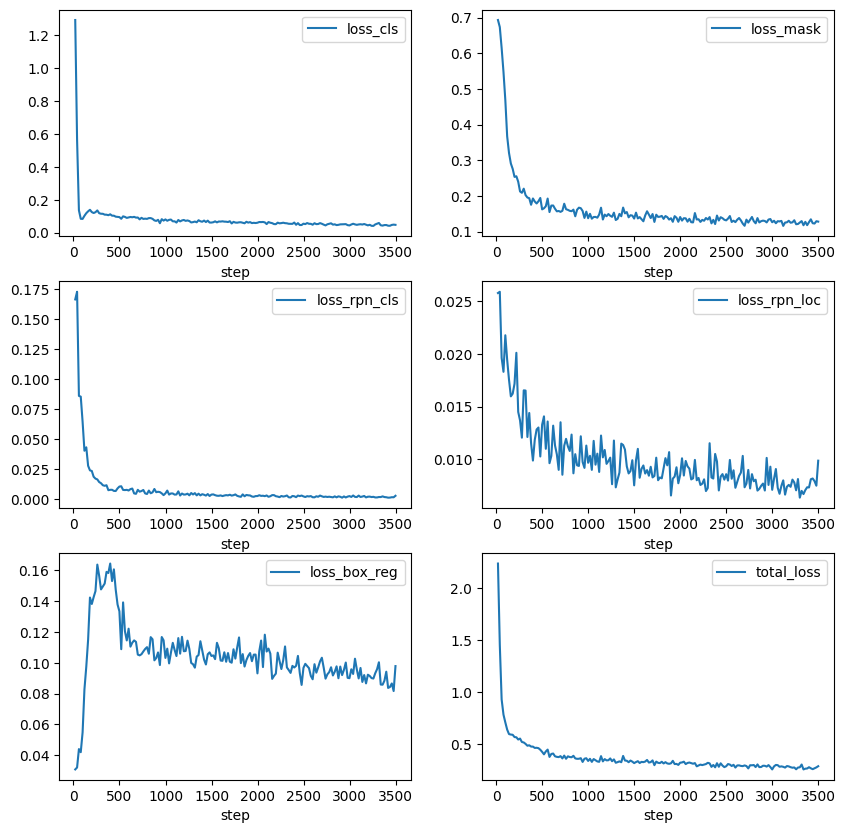

In [32]:
fig, ax = plt.subplots(3,2, figsize=(10, 10))

final_model_metrics.plot(y='loss_cls', ax=ax[0][0], label='loss_cls')
final_model_metrics.plot(y='loss_mask', ax=ax[0][1], label='loss_mask')
final_model_metrics.plot(y='loss_rpn_cls', ax=ax[1][0], label='loss_rpn_cls')
final_model_metrics.plot(y='loss_rpn_loc', ax=ax[1][1], label='loss_rpn_loc')
final_model_metrics.plot(y='loss_box_reg', ax=ax[2][0], label='loss_box_reg')
final_model_metrics.plot(y='total_loss', ax=ax[2][1], label='total_loss')

plt.show()

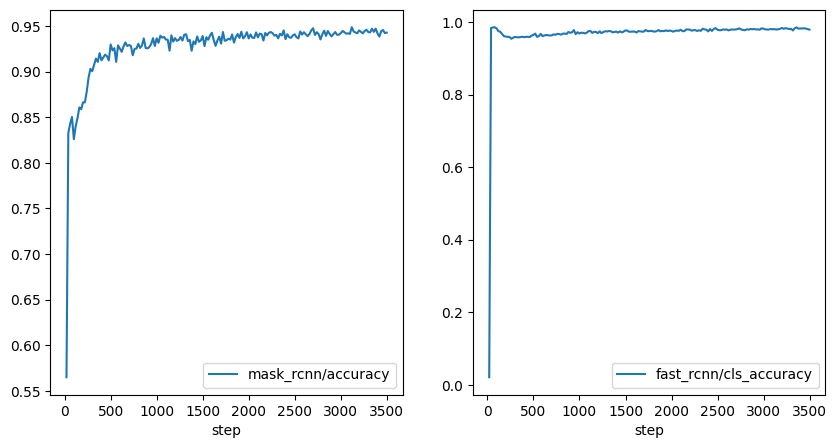

In [33]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

final_model_metrics.plot(y='mask_rcnn/accuracy', ax=ax[0], label='mask_rcnn/accuracy')
final_model_metrics.plot(y='fast_rcnn/cls_accuracy', ax=ax[1], label='fast_rcnn/cls_accuracy')

plt.show()